# Run libraries

In [8]:
library(ggplot2)
library(patchwork)

# Define the combined plotting function
plot_umap_expression <- function(norm_matrix, umap_coordinate, genes, cluster = NULL, cluster_gene_results = NULL) {
  # Initialize plot list
  all_plots <- list()
  
  # Handle different input types
  if (!is.null(cluster) && !is.null(cluster_gene_results)) {
    # Extract genes for the specified cluster
    genes <- cluster_gene_results[[cluster]]$genes
  }
  
  # Iterate over the provided genes
  for (gene in genes) {
    if (gene %in% rownames(norm_matrix)) {
      # Extract gene expression values
      gene_expression <- norm_matrix[gene, ]
      
      # Create a data frame for UMAP plotting
      umap_df <- data.frame(
        UMAP1 = umap_coordinate[, 1],
        UMAP2 = umap_coordinate[, 2],
        Expression = gene_expression
      )
      
      # Plot UMAP with gene expression
      p <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Expression)) +
        geom_point(size = 2) +
        scale_color_gradient(low = "gray", high = "blue") +  # Color gradient
        theme_minimal() +
        labs(
          title = if (!is.null(cluster)) paste("Cluster", cluster, "-", gene) else gene,
          color = "Expression"
        ) +
        theme(
          plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank()
        )
      
      # Add plot to list
      all_plots <- append(all_plots, list(p))
    } else {
      cat("Gene", gene, "not found in norm_matrix\n")
    }
  }
  
  return(all_plots)
}

Warning message:
“package ‘patchwork’ was built under R version 4.3.3”


## Run prerequest Functions for CIARA

In [3]:
get_background_full_here = function (norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20,
    extend_binarization = FALSE, quant_threshold = 0.9, quant_low = 0.1,
    quant_high = 0.9)
{
    if (!(is.logical(extend_binarization))) {
        stop("extend_binarization must be a logical value. Try with extend_binarization = TRUE or extend_binarization = FALSE")
    }
    if (extend_binarization == FALSE) {
        genes_filter <- apply(norm_matrix, 1, function(x) {
            x <- x[x > threshold]
            if (length(x) >= n_cells_low) {
                return(TRUE)
            }
            else {
                return(FALSE)
            }
        })
        genes_filter_2 <- apply(norm_matrix, 1, function(x) {
            x <- x[x > threshold]
            if (length(x) > n_cells_high) {
                return(FALSE)
            }
            else {
                return(TRUE)
            }
        })
        genes_important <- row.names(norm_matrix)[genes_filter]
        genes_important_2 <- row.names(norm_matrix)[genes_filter_2]
        genes_important_final <- intersect(genes_important, genes_important_2)
        if (length(genes_important_final) == 0) {
            stop("There are not genes that pass the filtering steps")
        }
        return(genes_important_final)
    }
    if (extend_binarization == TRUE) {
        diff_quant <- apply(norm_matrix, 1, function(x) {
            quant_low_th <- quantile(x, quant_low)
            quant_high_th <- quantile(x, quant_high)
            diff_quant <- as.numeric(quant_high_th - quant_low_th)
            return(diff_quant)
        })
        quant_threshold_value <- quantile(diff_quant, quant_threshold)
        if (quant_threshold_value > 0) {
            genes_important_final <- row.names(norm_matrix)[diff_quant >=
                quant_threshold_value]
        }
        if (quant_threshold_value == 0) {
            warning("All the genes are tested. Try with an higher quant_threshold to test a smaller set of genes ")
            genes_important_final <- row.names(norm_matrix)[diff_quant >=
                quant_threshold_value]
        }
        if (length(genes_important_final) == 0) {
            stop("There are not genes that pass the filtering steps")
        }
        return(genes_important_final)
    }
}

###########################################
CIARA_final = function (norm_matrix, knn_matrix, background, cores_number = 1, 
    fdr_value = 0.05, n_cells, approximation = FALSE) 
{
  Matrix::diag(knn_matrix) <- 0
    
  denominator = (as.numeric(length(colnames(norm_matrix)))*as.numeric(length(colnames(norm_matrix))))
  number_binomial = n_cells*n_cells
  probability_combined = (sum(knn_matrix>0))/denominator
  
    run_loop_genes = function(i) {
        if (!all(background %in% row.names(norm_matrix))) {
            stop("Some background genes are not present in norm matrix")
        }
        gene_expression <- as.vector(norm_matrix[background[i], 
            ])
        #message(paste0("Running CIARA on gene:", background[i]))
        return(CIARA_gene_final(norm_matrix, knn_matrix, gene_expression,n_cells, denominator,number_binomial, probability_combined, approximation))
    }
    result_final <- (do.call(rbind, mclapply(seq_len(length(background)), 
        run_loop_genes, mc.cores = cores_number)))
    row.names(result_final) <- background
    if (approximation == FALSE){
    colnames(result_final) <- c("rank_genes","p_value","rank_genes_final")
    fdr_values <- as.vector(p.adjust(as.vector(result_final[,2]), method ="fdr"))
    result_final <- cbind(result_final,fdr_values)
    result_final <- result_final[result_final[,4]<= fdr_value, ]  
    return(result_final)
    }
    if (approximation == TRUE){
      colnames(result_final) <- c("rank_genes","rank_genes_final")
      result_final <- result_final[result_final[,2]>=1,]
    
    
    return(result_final)
    }
}

###########################################
CIARA_gene_final = function (norm_matrix, knn_matrix, gene_expression, n_cells, denominator,number_binomial, probability_combined, approximation = FALSE)
{




  
  if (approximation == FALSE){
    names(gene_expression) = colnames(norm_matrix)
    gene_expression_sort = sort(gene_expression, decreasing = T)
    gene_expression_sort= gene_expression_sort[gene_expression_sort!=0]
    if (length(gene_expression_sort) >= n_cells ){
    gene_expression_sort_top = gene_expression_sort[1:n_cells]
    }
    else{
      gene_expression_sort_top = gene_expression_sort
    }
    sub_feature = names(gene_expression_sort_top)
    knn_matrix_small <- knn_matrix[sub_feature,sub_feature]
    rank_gene = sum(as.vector(knn_matrix_small)>0)
    
    #rank_gene_final = rank_gene 
   # number_binomial = n_cells*n_cells
 # probability_combined = (sum(knn_matrix>0))/denominator
    
      #rank_gene_final = rank_gene 
   # number_binomial = n_cells*n_cells
  #probability_combined = (sum(knn_matrix>0))/denominator
    
    pvalue_binomial <- binom.test(rank_gene,number_binomial, 
        probability_combined, alternative = c("greater"))$p.value


    return(list(rank_gene, pvalue_binomial,rank_gene))
}
  

  if (approximation == TRUE) {
    names(gene_expression) = colnames(norm_matrix)
  gene_expression_sort = sort(gene_expression, decreasing = T)
  gene_expression_sort= gene_expression_sort[gene_expression_sort!=0]
  if (length(gene_expression_sort) >= n_cells ){
    gene_expression_sort_top = gene_expression_sort[1:n_cells]
  }
  else{
    gene_expression_sort_top = gene_expression_sort
  }
  sub_feature = names(gene_expression_sort_top)
  knn_matrix_small <- knn_matrix[sub_feature,sub_feature]
  rank_gene = sum(as.vector(knn_matrix_small)>0)
  if ( rank_gene >= n_cells){
    rank_gene_final = rank_gene
  
  }
  else{
    n_cells_here = length(gene_expression_sort)
    rank_gene_final = rank_gene 
    
  }
  


  return(list(rank_gene,rank_gene_final))
    
  }
}

###########################################
detect_localized_genes_final=function (knn_matrix, norm_matrix, genes_sort, top_number, threshold = 1,cores_number =1, approximation = FALSE, extend_binarization = FALSE, n_cells = 10) {
  
  
  Matrix::diag(knn_matrix) <- 0
  if (!is.logical(approximation)){
    stop(paste0("approximation must be logical"))
  }
  
  if (!is.logical(extend_binarization)){
    stop(paste0("extend_binarization must be logical"))
  }
  
  if (extend_binarization == TRUE){
  norm_matrix_extend = apply(norm_matrix[genes_sort,],1,function(x){
    names(x) = colnames(norm_matrix)
    x_sort = sort(x, decreasing = T)
    x_sort= x_sort[x_sort!=0]
    if (length(x_sort) >= n_cells ){
   x_sort_top = x_sort[1:n_cells]
    }
    else{
      x_sort_top = x_sort
    }
    y = rep(0,length(x))
    y[colnames(norm_matrix)%in%names(x_sort_top)] =1 
    return(y)
  }
  
  )
  
  norm_matrix_extend = t(norm_matrix_extend)
  colnames(norm_matrix_extend) = colnames(norm_matrix)
  norm_matrix = norm_matrix_extend
  threshold = 0
  }
  
  if (approximation == FALSE){
    run_localized_genes = function(i){       
  #print(i)
       knn_name = (which(knn_matrix[i, ] > 0))
        genes_select <- genes_sort[1:top_number]
        sum_knn <- apply(norm_matrix[genes_select, knn_name], 
            2, function(x) {
                somma <- genes_select[which(x > threshold)]
                return(somma)
            })
        list_intersect<- unique(as.vector(unlist(sum_knn))[duplicated(as.vector(unlist(sum_knn)))])
        rank_intersect <- length(list_intersect)
        #print(rank_intersect)
        return(list(list_intersect,rank_intersect))
    }
    result_final <- do.call(rbind, mclapply(seq_len(length(colnames(knn_matrix))), 
        run_localized_genes, mc.cores = cores_number))
    
    
result_final=as.data.frame(result_final)

list_intersect = result_final[,1]
rank_intersect = unlist(result_final[,2])

    return(list(rank_intersect,list_intersect))
  }
  
  if (approximation == TRUE){
 
  genes_select <- genes_sort[1:top_number]
  cells_kept = apply(norm_matrix[genes_select,],2,function(x){
    somma <- sum(x>threshold)
    if (somma >=1){
      return(TRUE)
    }
    else{
      return(FALSE)
    }
  })
  
  cells_kept_final=colnames(norm_matrix)[cells_kept]
  
  #print(length(cells_kept_final))
  
  norm_matrix_small = norm_matrix
  knn_matrix_small = knn_matrix[cells_kept_final,]
  
  
  run_localized_genes = function(i){       
  #print(i)
       #knn_name = names(which(knn_matrix[i, ] > 0))
       knn_name = (which(knn_matrix_small[i, ] > 0))
        genes_select <- genes_sort[1:top_number]
        sum_knn <- apply(norm_matrix_small[genes_select, knn_name], 
            2, function(x) {
                somma <- genes_select[which(x > threshold)]
                return(somma)
            })
        list_intersect<- unique(as.vector(unlist(sum_knn))[duplicated(as.vector(unlist(sum_knn)))])
        rank_intersect <- length(list_intersect)
        #print(rank_intersect)
        return(list(list_intersect,rank_intersect))
    }
    result_final <- do.call(rbind, mclapply(seq_len(length(row.names(knn_matrix_small))), 
        run_localized_genes, mc.cores = cores_number))
    
   
  
  result_final=as.data.frame(result_final)

list_intersect = result_final[,1]
rank_intersect = unlist(result_final[,2])

 rank_intersect_final = rep(0,length(cells_kept))
  rank_intersect_final[cells_kept] = rank_intersect
  
  list_intersect_final = rep(list(character(0)),length(cells_kept))
  list_intersect_final[cells_kept] = list_intersect
  
    return(list(rank_intersect_final,list_intersect_final))
  } 
}

###########################################

find_cluster_final = function(rank_intersect,list_intersect, norm_matrix, min_loc_genes = 1){
  
  
  #rank_intersect = rank_intersect
  #list_intersect = list_intersect
  #norm_mtrix = norm_matrix
  #knn_matrix = knn_matrix
  #min_loc_genes = 5
  #threshold_jaccard = 0.5
  
if(min_loc_genes >= max(rank_intersect)){
  stop(paste0("min_loc_genes must be lower than ", max(rank_intersect)))
}
list_intersect_small = list_intersect[rank_intersect>min_loc_genes]



matrix_common = matrix(0,ncol = length(list_intersect_small),nrow = length(list_intersect_small))

## Find common localized genes between cells i and j
for (i in 1:length(list_intersect_small)){
  for (j in 1:length(list_intersect_small)){
    if (length((as.vector(list_intersect_small[i])[[1]])) >0 & length((as.vector(list_intersect_small[j])[[1]]))>0){ 
  matrix_common[i,j]=length(intersect(as.vector(list_intersect_small[i])[[1]],as.vector(list_intersect_small[j])[[1]]))
      
    }
    else{
      matrix_common[i,j] = 0
    }
  }
}

## If the intersection is below a given threshold, then the entry is set to 0
matrix_common_new=matrix_common

for (i in 1:length(list_intersect_small)){
  for (j in 1:length(list_intersect_small)){
    if (matrix_common[i,j]<=min_loc_genes ){  
  matrix_common_new[i,j]=0
    }
    else{
      matrix_common_new[i,j] = matrix_common[i,j]
    }
  }
}



matrix_common=as.data.frame(matrix_common)

colnames(matrix_common_new)=colnames(norm_matrix)[rank_intersect>min_loc_genes]

row.names(matrix_common_new)=colnames(norm_matrix)[rank_intersect>min_loc_genes]

common_cells_update = rep(list(0),length(row.names(matrix_common)))



jaccard_matrix_new=matrix_common_new

k=1
l =1
iter=1
common_cells = rep(list(0),length(row.names(matrix_common)))
while(k>0){
 
  

index_common = which(jaccard_matrix_new[k,]> min_loc_genes )


if (length(index_common)<=2){
  
  iter=iter+1
  k=k+1
  index_plus = colnames(jaccard_matrix_new)[index_common]

jaccard_matrix_new = jaccard_matrix_new[!row.names(jaccard_matrix_new)%in%index_plus, !row.names(jaccard_matrix_new)%in%index_plus]
}
if (length(index_common)>2){

test_jaccard = jaccard_matrix_new[index_common,]
max_test_jaccard= apply(test_jaccard,1,function(x){
  index = (which(x == max(x)))
  relevant_index = which(x>0)
  cells_here = colnames(test_jaccard)[colnames(test_jaccard)%in%row.names(test_jaccard)]
    cells_not_here = colnames(test_jaccard)[!colnames(test_jaccard)%in%row.names(test_jaccard)]
    
    relevant_cells = colnames(test_jaccard)[relevant_index]
    
    sum_here = sum(relevant_cells %in% cells_here)
    sum_not_here = sum(relevant_cells %in% cells_not_here)
    
  
    if ((sum(colnames(test_jaccard)[index]%in%row.names(test_jaccard)) > 0) & (sum_here > sum_not_here) & (sum_here>=3)  )
    return(TRUE)
  else{
    #print("IS FALSE")
    return(FALSE)
    }
})

index_common_update= index_common[max_test_jaccard]
index_plus = colnames(jaccard_matrix_new)[index_common_update]
common_cells[[l]]=index_plus
  
jaccard_matrix_new = jaccard_matrix_new[!row.names(jaccard_matrix_new)%in%common_cells[[l]],!row.names(jaccard_matrix_new)%in%common_cells[[l]]]

k = 1
l =l +1
iter=iter+1
}
if (length(row.names(jaccard_matrix_new)) <= 2){
  k=0
  break
}

if (iter > length(row.names(matrix_common_new))){
  break
}
if (k>length(row.names(jaccard_matrix_new))){
  break
}
}

common_cells_small = common_cells[lengths(common_cells)>2]
return(common_cells_small)

}

###########################################
explore_genes_final = function(rank_intersect,list_intersect, norm_matrix,min_gene, max_gene, step_gene){
  
try_min_loc_genes = seq(min_gene,max_gene,step_gene)
cells_min_loc_genes = rep(list(0),length(try_min_loc_genes))


for (i in 1:length(try_min_loc_genes)){
  cells_min_loc_genes[[i]] = find_cluster_final(rank_intersect,list_intersect,norm_matrix, min_loc_genes = try_min_loc_genes[i])
}


all_cells= unlist(cells_min_loc_genes)
all_cells = unique(all_cells)

cluster_start_list = rep(list(0),length(try_min_loc_genes))
for (i in 1:length(try_min_loc_genes)){
cluster_start=rep("Other cluster",length(all_cells))
if(length(cells_min_loc_genes[[i]])>0){
cells_min_loc_genes_single = cells_min_loc_genes[[i]]
for (j in 1:length(cells_min_loc_genes_single)){
cluster_start[all_cells%in%cells_min_loc_genes_single[[j]] ] = j
}
cluster_start_list[[i]] = cluster_start
}
else{
 cluster_start_list[[i]] = rep("Other cluster",length(all_cells))
}
}

cluster_matrix=matrix(unlist(cluster_start_list), byrow=FALSE, ncol = length(cluster_start_list) )

iterat = seq(min_gene,max_gene,step_gene)
iterat_name=paste0("G",iterat)
colnames(cluster_matrix)=iterat_name
row.names(cluster_matrix) = all_cells
p = clustree(cluster_matrix, prefix = "G")

p
return(list(p,cluster_matrix))
}

###########################################

find_number_clusters_final = function(norm_matrix,rank_intersect,list_intersect, threshold = 0.50, min_genes_common = 8, max_rank_intersect = 20 ){
  
  #norm_matrix = norm_matrix_neuron_small
  #rank_intersect = rank_here
  #threshold = 0.50
  #min_genes_common = 3
  #max_rank_intersect = 20
  #min_gene = 1
  #list_intersect = list_intersect_here
if (max(rank_intersect) <= max_rank_intersect ){
  if (max(rank_intersect) >= 10){
  #min_genes_common = round(0.4* max(rank_intersect_atac),1)
  }
  else{
    #min_genes_common = 3
  }
  #max_rank_intersect = max(rank_intersect)
  
  
}
  
  max_gene = max_rank_intersect
  step_gene = 1
  #min_gene = min_genes_common - 1
  min_gene = 1
  
  out_explore_genes = explore_genes_final(rank_intersect,list_intersect,norm_matrix,min_gene, max_gene, step_gene)
  cluster_matrix = out_explore_genes[[2]]
cluster_g1 = names(table(cluster_matrix[,1]))
cluster_g1 = cluster_g1[cluster_g1!="Other cluster"]
score_g1 = rep(list(0),length(cluster_g1))
for ( i in 1:length(cluster_g1)){
  cluster_name = cluster_g1[i]
  cluster_all_name = cluster_matrix[,1]
  cells_name = row.names(cluster_matrix)[cluster_all_name == cluster_name]
   count = 0
   for (j in 1:length(colnames(cluster_matrix))){
  
     cluster_j = cluster_matrix[cells_name,j]
     cluster_j = cluster_j[cluster_j!="Other cluster"]
     count_next = as.vector(table(cluster_j))
    
     if (sum(count_next > threshold*length(cells_name))>=1){
       count = count+1
     }
   }
  score_g1[[i]] = count
  names(score_g1[[i]])=cluster_g1[i]
}

clusters = names(unlist(score_g1))
score = as.vector(unlist(score_g1))
data = data.frame(clusters, score)
p<-ggplot(data, aes(x=clusters, y=score)) +
  geom_bar(stat="identity") + ylim(c(0,max(score))) + scale_y_continuous(breaks= seq(0,max(score),1), limits=c(0, max(score)))

if (sum(score>=min_genes_common)>=1){
  final_clu = find_cluster_final(rank_intersect,list_intersect,norm_matrix, min_loc_genes = min_gene)
  
  cluster_final=rep("Other cluster",length(colnames(norm_matrix)))


for (i in 1:length(final_clu)){
cluster_final[colnames(norm_matrix)%in%final_clu[[i]]] = i
}
  
 cluster_final[!cluster_final %in% cluster_g1[score>=min_genes_common] ] =  "Other cluster"
 
 cluster_rare = names(table(cluster_final))[names(table(cluster_final))!="Other cluster"]
marker_final = rep(list(0), length(cluster_rare))

for (i in 1:length(cluster_rare)){

marker_final[[i]] = unique(unlist(list_intersect[cluster_final%in%cluster_rare[i]]))
}

if (length(marker_final) >1){
common_genes = Reduce(intersect,marker_final)


if (length(common_genes)>=1){
  for (i in 1:length(cluster_rare)){

marker_final[[i]] = marker_final[[i]][!marker_final[[i]]%in%common_genes]
}
}
}


## New part
min_gene_final = min_genes_common - 1
#min_gene_final = min_genes_common 
final_clu_max = find_cluster_final(rank_intersect,list_intersect,norm_matrix, min_loc_genes = min_gene_final)


cluster_final_max=rep("Other cluster",length(colnames(norm_matrix)))
kept_cells = colnames(norm_matrix)[cluster_final%in%cluster_rare]
  for (i in 1:length(final_clu_max)){
    final_clu_max[[i]] = intersect(final_clu_max[[i]],kept_cells)
cluster_final_max[colnames(norm_matrix)%in%final_clu_max[[i]]] = i

  }

cluster_rare_max = names(table(cluster_final_max))[names(table(cluster_final_max))!="Other cluster"]
marker_final_max = rep(list(0), length(cluster_rare_max))

for (i in 1:length(cluster_rare_max)){

marker_final_max[[i]] = unique(unlist(list_intersect[cluster_final_max%in%cluster_rare_max[i]]))
#marker_final_max[[i]] = Reduce(intersect,list_intersect[cluster_final_max%in%cluster_rare_max[i]])
}

if (length(marker_final_max) >1){
  
#common_genes_max = Reduce(intersect,marker_final_max)
common_genes_all = unlist(marker_final_max)
common_genes_all = unique(common_genes_all[!isUnique(unlist(marker_final_max))])
#index_merge = rep(list(0),length(marker_final_max))
#for (j in 1:length(marker_final_max)){
#index_common = which(marker_final_max[[j]]%in%common_genes_all)
#if (index_common >= min_gene_final){
  #index_merge[[j]] = j
#}
#}
#index_merge_all = unlist(index_merge)

if (length(common_genes_all)>=1){
  index_remove = rep(0,length(cluster_rare_max))
  for (i in 1:length(cluster_rare_max)){

marker_final_max[[i]] = marker_final_max[[i]][!marker_final_max[[i]]%in%common_genes_all]

if (length(marker_final_max[[i]]) <= min_gene_final){
  index_remove[i] = i
}
  }
  
  if (sum(index_remove)>0){

    #print(marker_final_max)
marker_final_max = marker_final_max[index_remove==0]
#print(marker_final_max)
cluster_final_max[cluster_final_max%in%c(cluster_rare_max[index_remove!=0])] = "Other cluster"
}
  
}



}


cluster_remove = names(table(cluster_final_max))[table(cluster_final_max)<3]
if (length(cluster_remove)>=1){
level_cluster_final = levels(factor(cluster_final_max))
level_cluster_final = level_cluster_final[level_cluster_final!="Other cluster"]
print(marker_final_max)
marker_final_max = marker_final_max[level_cluster_final!=cluster_remove]
#print(marker_final_max)
#print(cluster_remove)
#print(level_cluster_final)
cluster_final_max[cluster_final_max%in%cluster_remove] = "Other cluster"
}

}

else{
  cluster_final_max=rep("Other cluster",length(colnames(norm_matrix)))
  marker_final_max = list(0)
}

return(list(out_explore_genes[[1]],p, score_g1, cluster_final_max, marker_final_max))
}

###########################################

plot_localized_genes_interactive_here = function (coordinate_umap, norm_matrix, rank_intersect, text,
    ramp_list, min_x = NULL, max_x = NULL, min_y = NULL, max_y = NULL)
{
    index_sort <- order(rank_intersect)
    text = text[index_sort]
    row.names(coordinate_umap) <- colnames(norm_matrix)
    coordinate_umap <- coordinate_umap[colnames(norm_matrix)[index_sort],
        ]
    rank_intersect <- sort(rank_intersect)
    if (!requireNamespace("plotly", quietly = TRUE)) {
        stop("Package plotly needed for interactive == TRUE. Please install it: install.packages('plotly')")
    }
    colnames(coordinate_umap) <- c("UMAP_1", "UMAP_2")
    fig <- plotly::plot_ly(data = coordinate_umap, x = ~UMAP_1,
        y = ~UMAP_2, type = "scatter", mode = "markers", marker = list(color = ~rank_intersect,
            size = 5, width = 2, line = list(color = "black",
                width = 0.5), colorbar = list(title = "Number of rare cell markers\nshared with neighbors"),
            showscale = TRUE, colorscale = ramp_list), text = ~text,
        hoverinfo = "text")
    if (!is.null(min_x)) {
        fig <- fig %>% plotly::layout(xaxis = list(range = c(min_x,
            max_x)), yaxis = list(range = c(min_y, max_y))) %>%
            plotly::layout(plot_bgcolor = "rgb(254, 247, 234)") %>%
            plotly::layout(paper_bgcolor = "rgb(254, 247, 234)")
    }
    return(fig)
}

###########################################
names_localized_genes=function (list_intersect, genes_sort, max_number = 5){ 
  text <- rep(0,length(list_intersect))
  
  for (i in 1:length(list_intersect)) {
    if (length(list_intersect[[i]]) == 0){
      localized_genes <- "No specific genes"
      text[i] <- "No specific genes"
      
    }
    else {
      localized_genes <- genes_sort[which(genes_sort %in% list_intersect[[i]])]
      
      max_genes <- min(max_number, length(localized_genes))
      if (max_genes < max_number){
        #warning("max_number bigger than length of localized_genes. Set max_number = length(localized_genes) ")
      }
      localized_genes <- localized_genes[1:max_genes]
      text[i] <- paste(localized_genes, collapse = "-")
      
      
    }
  }
  return(text)
}

###########################################
###########################################
###########################################

# Read data

In [1]:
library(readr)
library(Seurat, quietly = TRUE, warn.conflicts = FALSE)
library(CIARA, quietly = TRUE, warn.conflicts = FALSE)

vedo=read_rds('../data/xenopus_combined_and_clustered_no_out.rds')
load( file='../data/norm_matrix_frog.Rda')
load( file='../data/knn_matrix_frog.Rda')
load( file='../data/umap_coordinate_frog.Rda')

vedo = UpdateSeuratObject(object = vedo)
norm_matrix = norm_matrix_frog
knn_matrix = knn_matrix_frog
umap_coordinate = umap_coordinate_frog
subset_data <- subset(vedo, idents = 9)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc ‘pca’

Updating matrix keys for DimReduc ‘umap’

Updating matrix keys for DimReduc ‘tsne’

Warning message:
“DimReduc pca changing from DimReduc to DimReduc”
Warning message:
“DimReduc umap changing from DimReduc to DimReduc”
Warning message:
“DimReduc tsne changing from DimReduc to DimReduc”
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in integrated

Updating slots in pca

Updating slots in umap

Setting umap DimReduc to global

Updating slots in tsne

Setting tsne DimReduc to global

No assay information could be found for FindIntegrationAnchors

Warning message:
“Adding a command log without

# Cluster rare cells type region by using CIARA

Loading required package: ggraph

Loading required package: ggplot2

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Scale for y is already present.
Ad

[[1]]


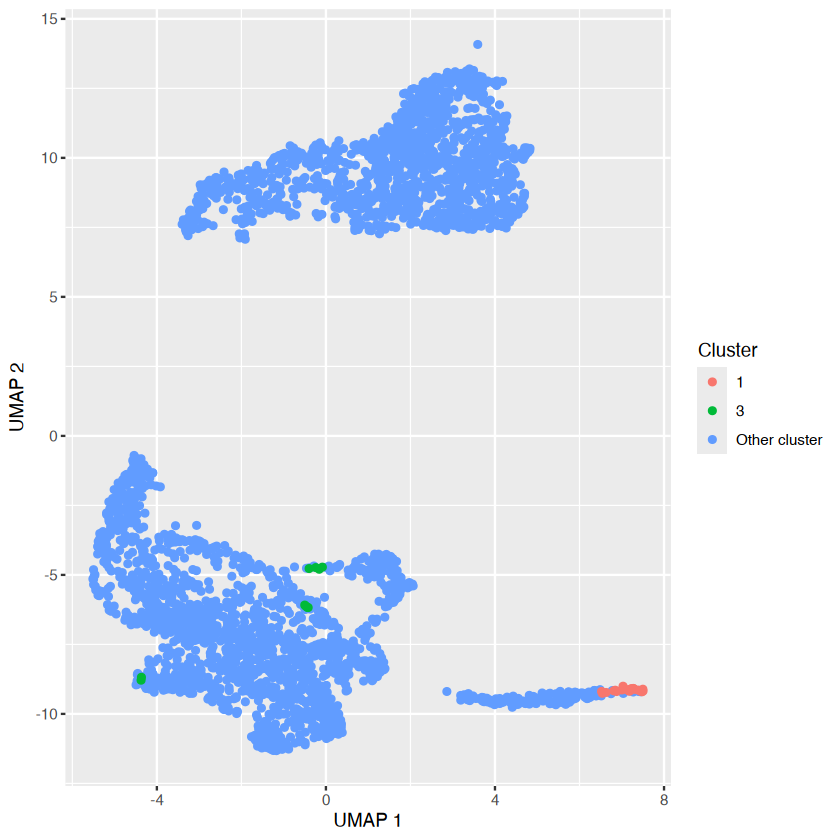

In [4]:
# Those codes are from Gabriele Lubatti
library(parallel)
background <- get_background_full_here(norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20)
result_antonio <- CIARA_final(norm_matrix, knn_matrix, background, cores_number = 1, fdr_value = 0.05, n_cells = 10, approximation = FALSE)


ciara_genes_new=row.names(result_antonio)
geni_top_top_new=row.names(result_antonio)[order(as.numeric(result_antonio[,4]), decreasing = FALSE)]


localized_genes_human <-  detect_localized_genes_final(knn_matrix,norm_matrix,geni_top_top_new,100, 1, approximation = FALSE)  
list_intersect_new <-  localized_genes_human[[2]]
rank_intersect_new <-  localized_genes_human[[1]]
genes_name_text <-  names_localized_genes(list_intersect_new ,geni_top_top_new,max_number = 5)

library(clustree)
library(Biobase)
final_partition = find_number_clusters_final(norm_matrix,rank_intersect_new,list_intersect_new, threshold = 0.50, min_genes_common = 4, max_rank_intersect = 20 )

cluster_new = final_partition[[4]]
index_first = which(cluster_new =="Other cluster")
index_second = which(cluster_new !="Other cluster") 
index_all = c(index_first,index_second)
umap_coordinate[3] <- cluster_new
library("dplyr")  
library(ggthemes)
plot_umap(umap_coordinate[index_all,], cluster_new[index_all]) #+ theme(strip.background = element_blank(), strip.text = element_text(face = 'bold'))

# Indentify DEGs, HVGs, and localized gene with cluster 1 and 3

## Use Seurat to find HVGs within cluster 1 and 3

Centering and scaling data matrix



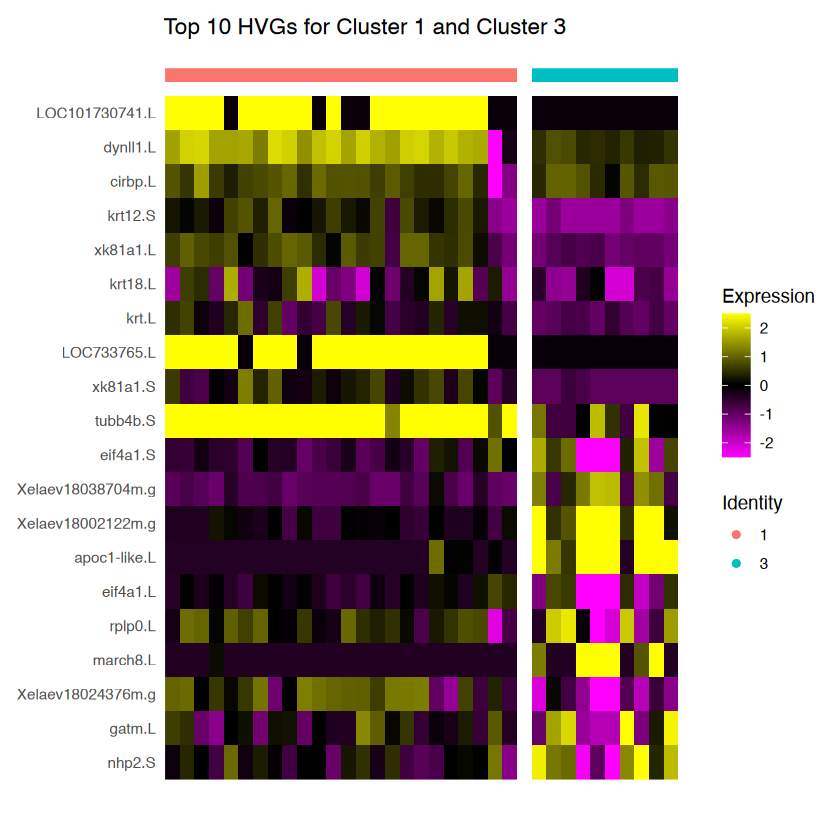

In [5]:
# Extract cells belonging to cluster 1 and cluster 3
cluster_1_cells <- colnames(norm_matrix)[cluster_new == "1"]
cluster_3_cells <- colnames(norm_matrix)[cluster_new == "3"]

# Create separate Seurat objects for cluster 1 and cluster 3
cluster_1_data <- CreateSeuratObject(counts = norm_matrix[, cluster_1_cells])
cluster_3_data <- CreateSeuratObject(counts = norm_matrix[, cluster_3_cells])

# Find HVGs (skip normalization)
cluster_1_data <- FindVariableFeatures(cluster_1_data, selection.method = "vst", nfeatures = 2000)
cluster_3_data <- FindVariableFeatures(cluster_3_data, selection.method = "vst", nfeatures = 2000)

# Retrieve the top 10 HVGs for each cluster
cluster_1_hvgs <- head(VariableFeatures(cluster_1_data), 10)
cluster_3_hvgs <- head(VariableFeatures(cluster_3_data), 10)

# Combine the HVGs from both clusters
combined_hvgs <- unique(c(cluster_1_hvgs, cluster_3_hvgs))

# Subset to include only the combined HVGs
subset_data_hvg <- subset(
  x = vedo, 
  features = combined_hvgs
)

# Scale data to ensure it can be visualized with DoHeatmap
subset_data_hvg <- ScaleData(subset_data_hvg, features = combined_hvgs)

# Add cluster annotation to metadata (if not already present)
subset_data_hvg$cluster_annotation <- factor(cluster_new)
subset_data_1_3 <- subset(
  x = subset_data_hvg, 
  subset = cluster_annotation %in% c("1", "3")
)# Generate the heatmap

# Ensure `cluster_annotation` is correctly set in the metadata
subset_data_1_3$cluster_annotation <- factor(subset_data_1_3$cluster_annotation)

# Generate the heatmap with legend
heatmap_plot <- DoHeatmap(
  object = subset_data_1_3,
  features = combined_hvgs,
  group.by = "cluster_annotation",
  label = FALSE  # Do not show cell names
) + 
  ggtitle("Top 10 HVGs for Cluster 1 and Cluster 3")

# Display the heatmap
print(heatmap_plot)

[[1]]



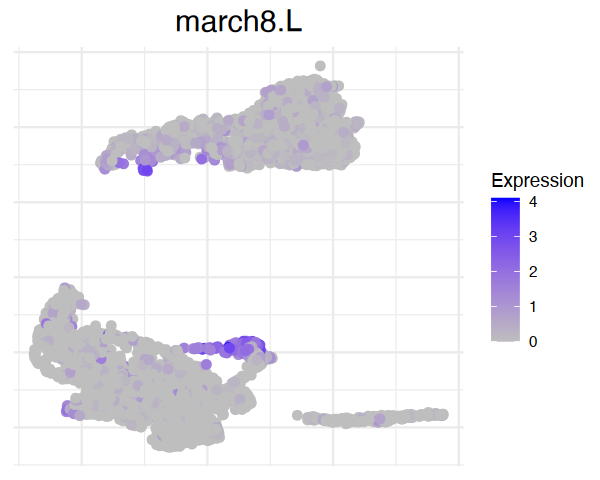

In [34]:
# Set plot width and height for JupyterLab
options(repr.plot.width = 5, repr.plot.height = 4)

# Generate the UMAP expression plot
march8_plot <- plot_umap_expression(
  norm_matrix = norm_matrix,
  umap_coordinate = umap_coordinate,
  genes = c("march8.L")
)


print(march8_plot)


## Use CIARA to find highly localized genes within cluster 1 and 3

In [6]:
# Step 1: Run CIARA globally
background <- get_background_full_here(norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20)
result <- CIARA_final(norm_matrix, knn_matrix, background, cores_number = 1, fdr_value = 0.05, n_cells = 10, approximation = FALSE)

# Step 2: Extract top genes per cluster
rare_clusters <- unique(cluster_new[index_second])  # Use rare cluster IDs
cluster_gene_results <- list()

for (cluster in rare_clusters) {
  # Select cell indices belonging to the current cluster
  cluster_indices <- which(cluster_new == cluster)
  
  # Compute mean expression for genes across cluster-specific cells
  cluster_expression <- rowMeans(norm_matrix[, cluster_indices, drop = FALSE])
  
  # Filter genes based on CIARA results
  ciara_genes <- row.names(result)
  cluster_specific_genes <- intersect(row.names(norm_matrix), ciara_genes)
  
  # Sort cluster-specific genes by expression
  cluster_gene_scores <- cluster_expression[cluster_specific_genes]
  top_genes <- names(sort(cluster_gene_scores, decreasing = TRUE))[1:10]
  
  # Store results
  cluster_gene_results[[cluster]] <- list(
    cluster = cluster,
    genes = top_genes
  )
}

# Step 3: Print the top genes for each cluster
for (cluster in names(cluster_gene_results)) {
  cat("\nTop genes for cluster:", cluster, "\n")
  print(cluster_gene_results[[cluster]]$genes)
}



Top genes for cluster: 1 
 [1] "LOC733765.L" "iqub.L"      "spag1.S"     "elovl2.L"    "pih1d2.L"   
 [6] "cep128.L"    "rgs19.L"     "ccdc40.S"    "cfap52.S"    "saxo2.L"    

Top genes for cluster: 3 
 [1] "gdf3.S"            "vegt.S"            "wnt11b.L"         
 [4] "t.S"               "Xelaev18013504m.g" "t.L"              
 [7] "t2.S"              "flrt3.S"           "rbm20.L"          
[10] "ventx3.2.L"       


## identify highly localized genes of cluster 1 and 3. 

In [7]:
background <- get_background_full_here(norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20) #131
result <- CIARA_final(norm_matrix, knn_matrix, background, cores_number = 1, fdr_value = 0.05, n_cells = 10, approximation = FALSE) #191
ciara_genes <- row.names(result)
top_genes <- ciara_genes[order(as.numeric(result[, 4]), decreasing = FALSE)][1:10]  # Top 10 genes
print(top_genes)


 [1] "gdf3.S"    "t2.S"      "vegt.S"    "ttll13p.L" "wnt11b.L"  "esr-5.L"  
 [7] "t.L"       "t.S"       "elovl2.L"  "rbm20.L"  


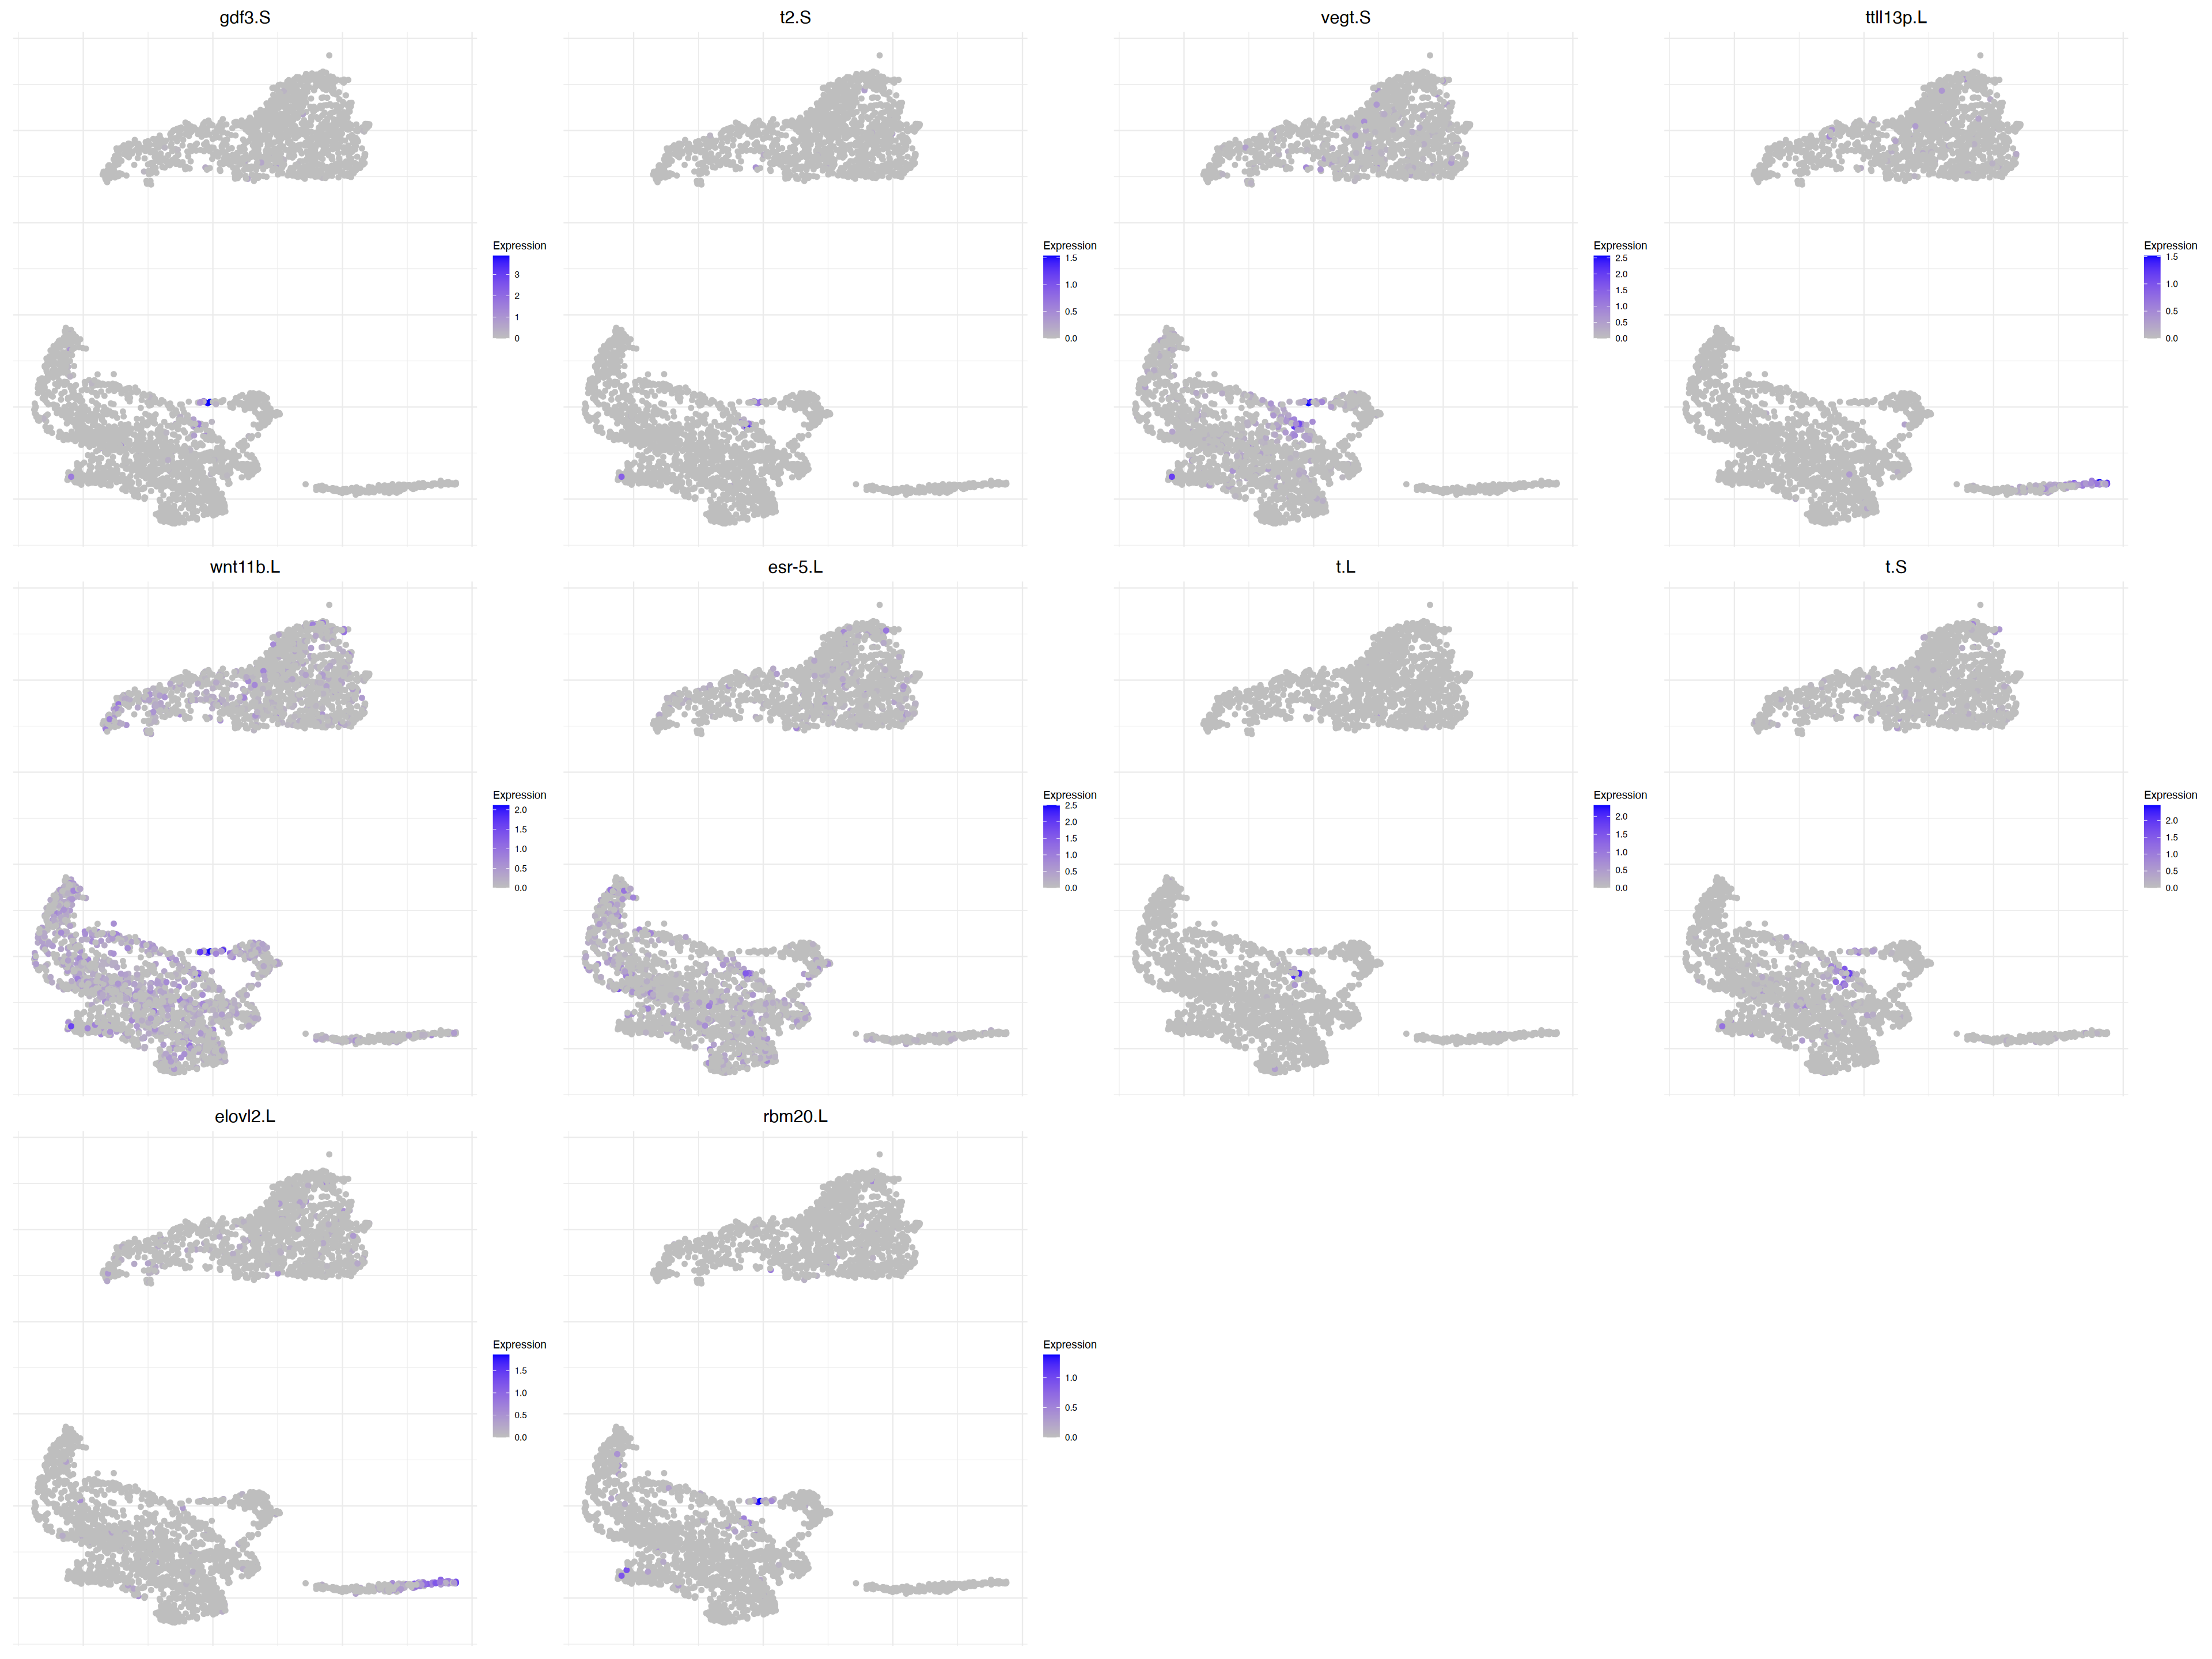

In [41]:
umap_plots_genes <- plot_umap_expression(
  norm_matrix = norm_matrix,
  umap_coordinate = umap_coordinate,
  genes = top_genes
)

#
combined_plot_genes <- wrap_plots(umap_plots_genes, ncol = 4)
print(combined_plot_genes)

## Plot the HVG of cluster 1,3

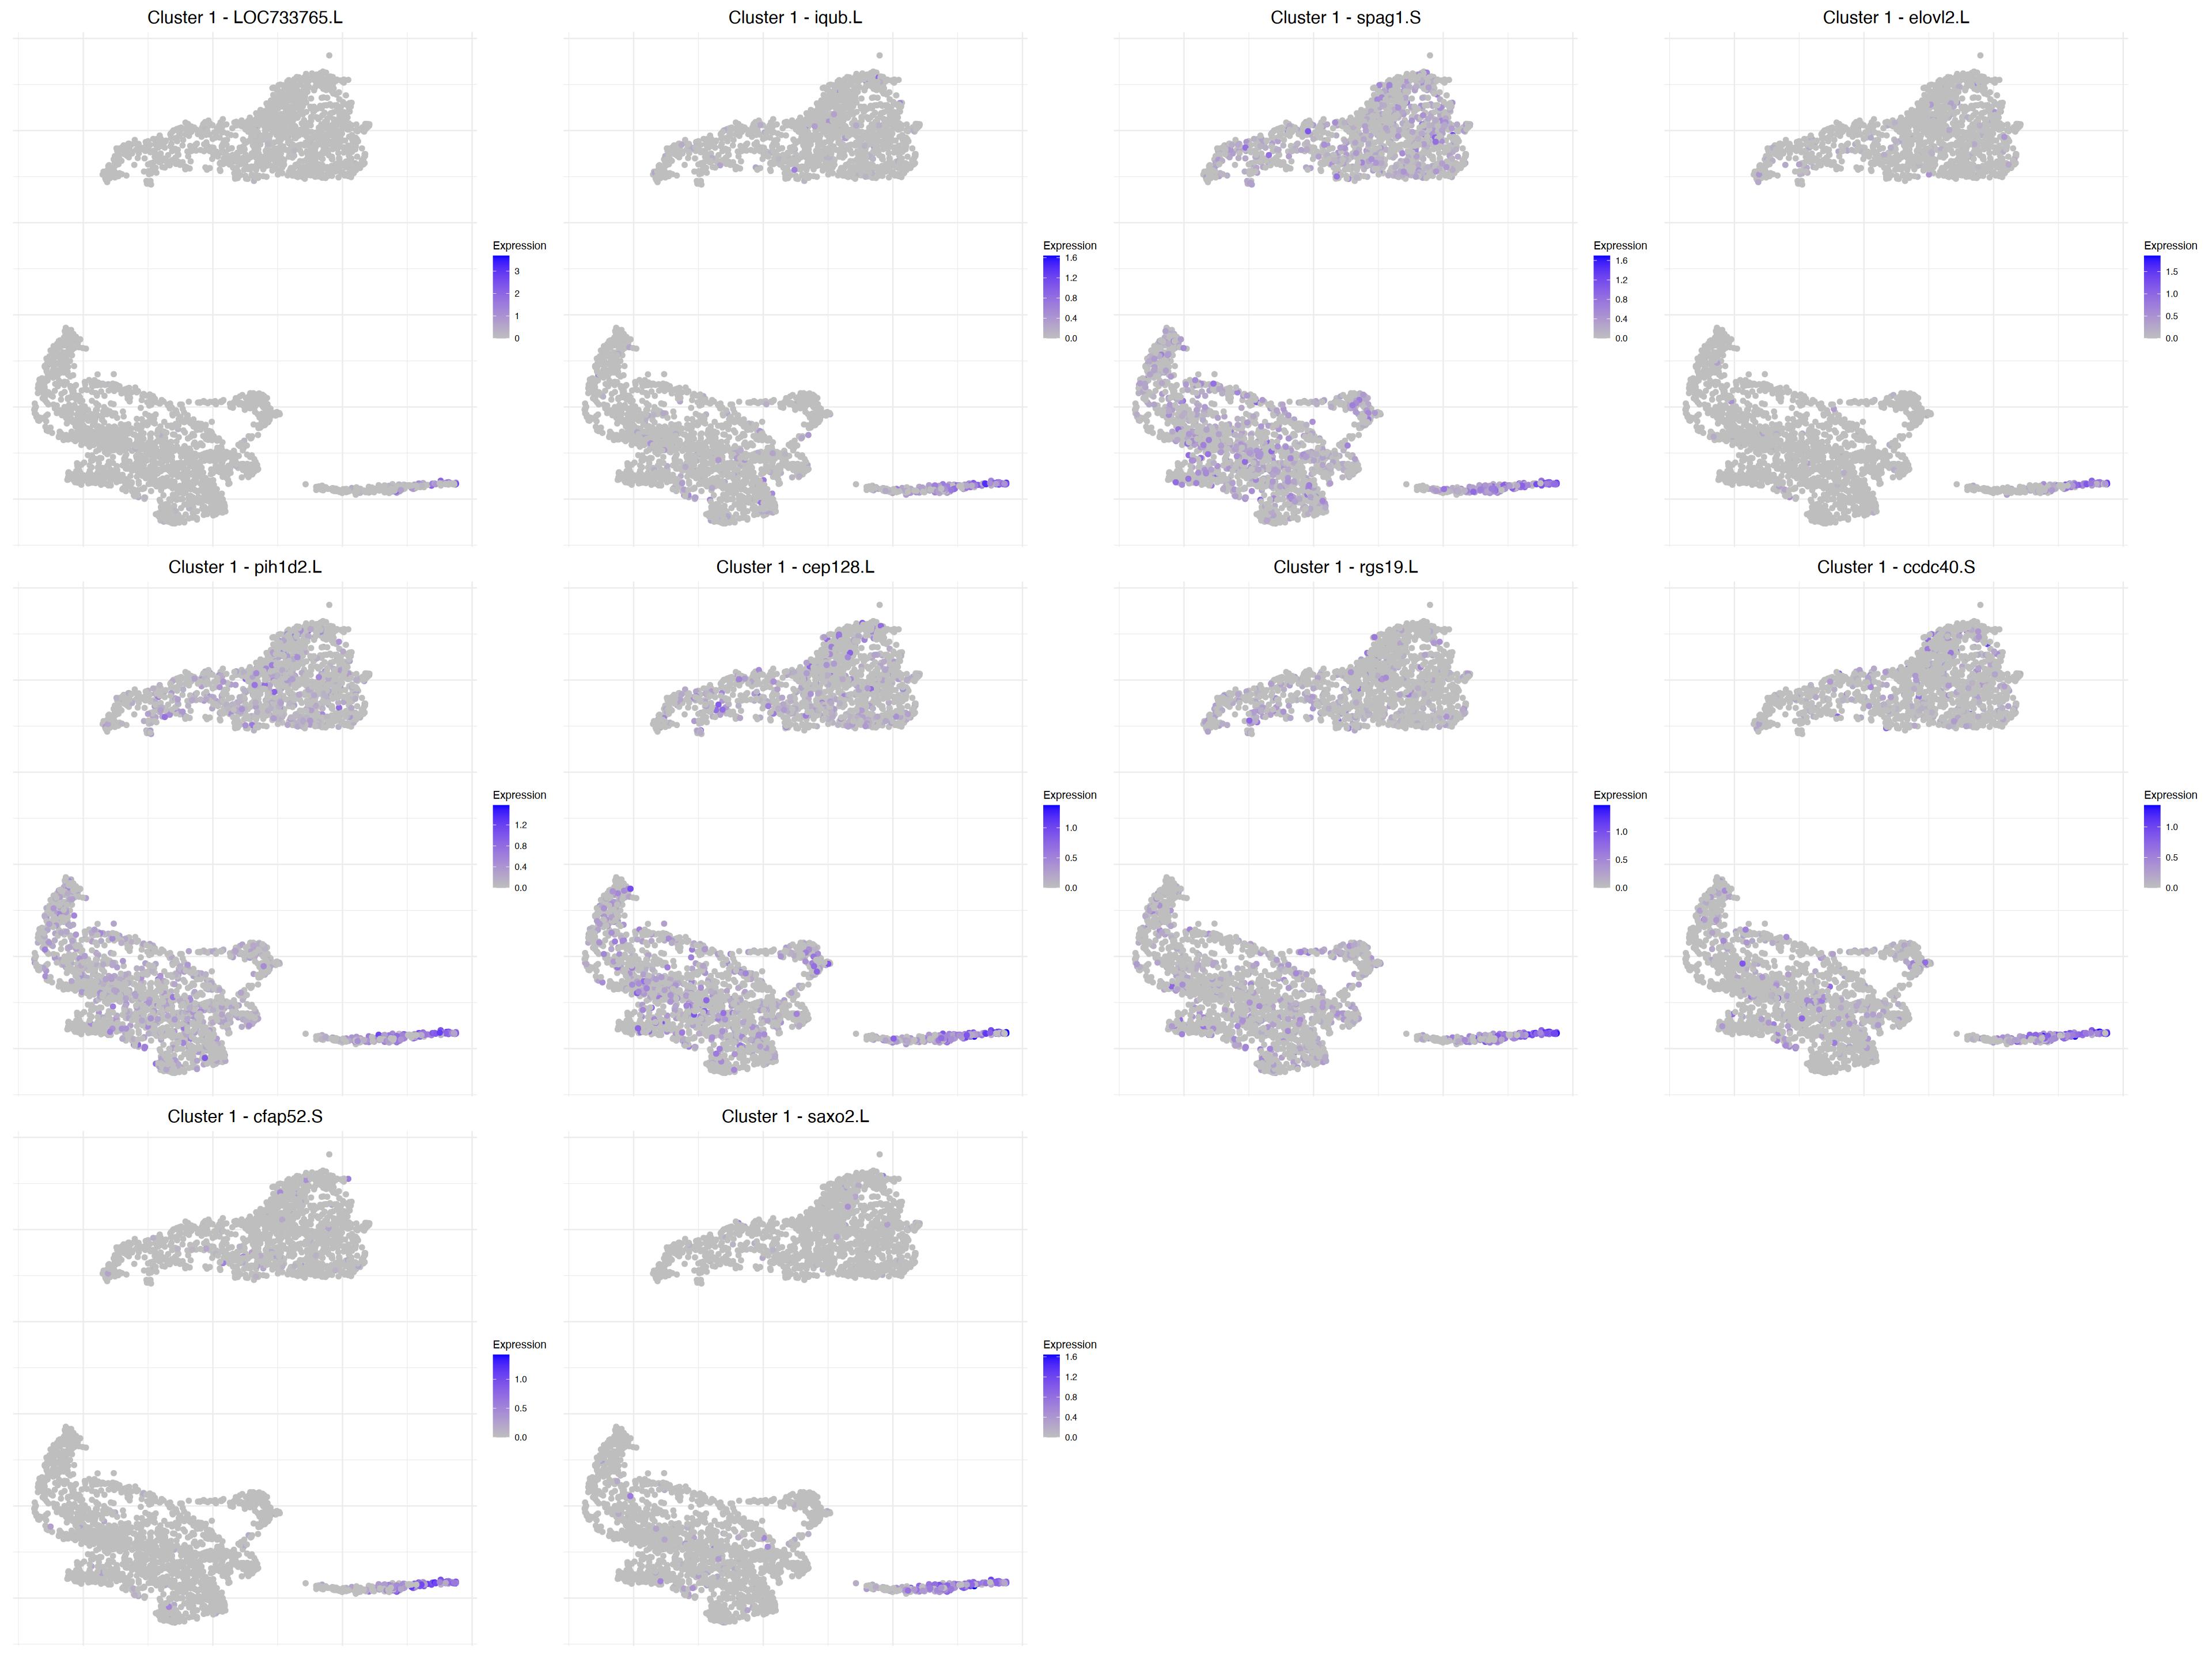

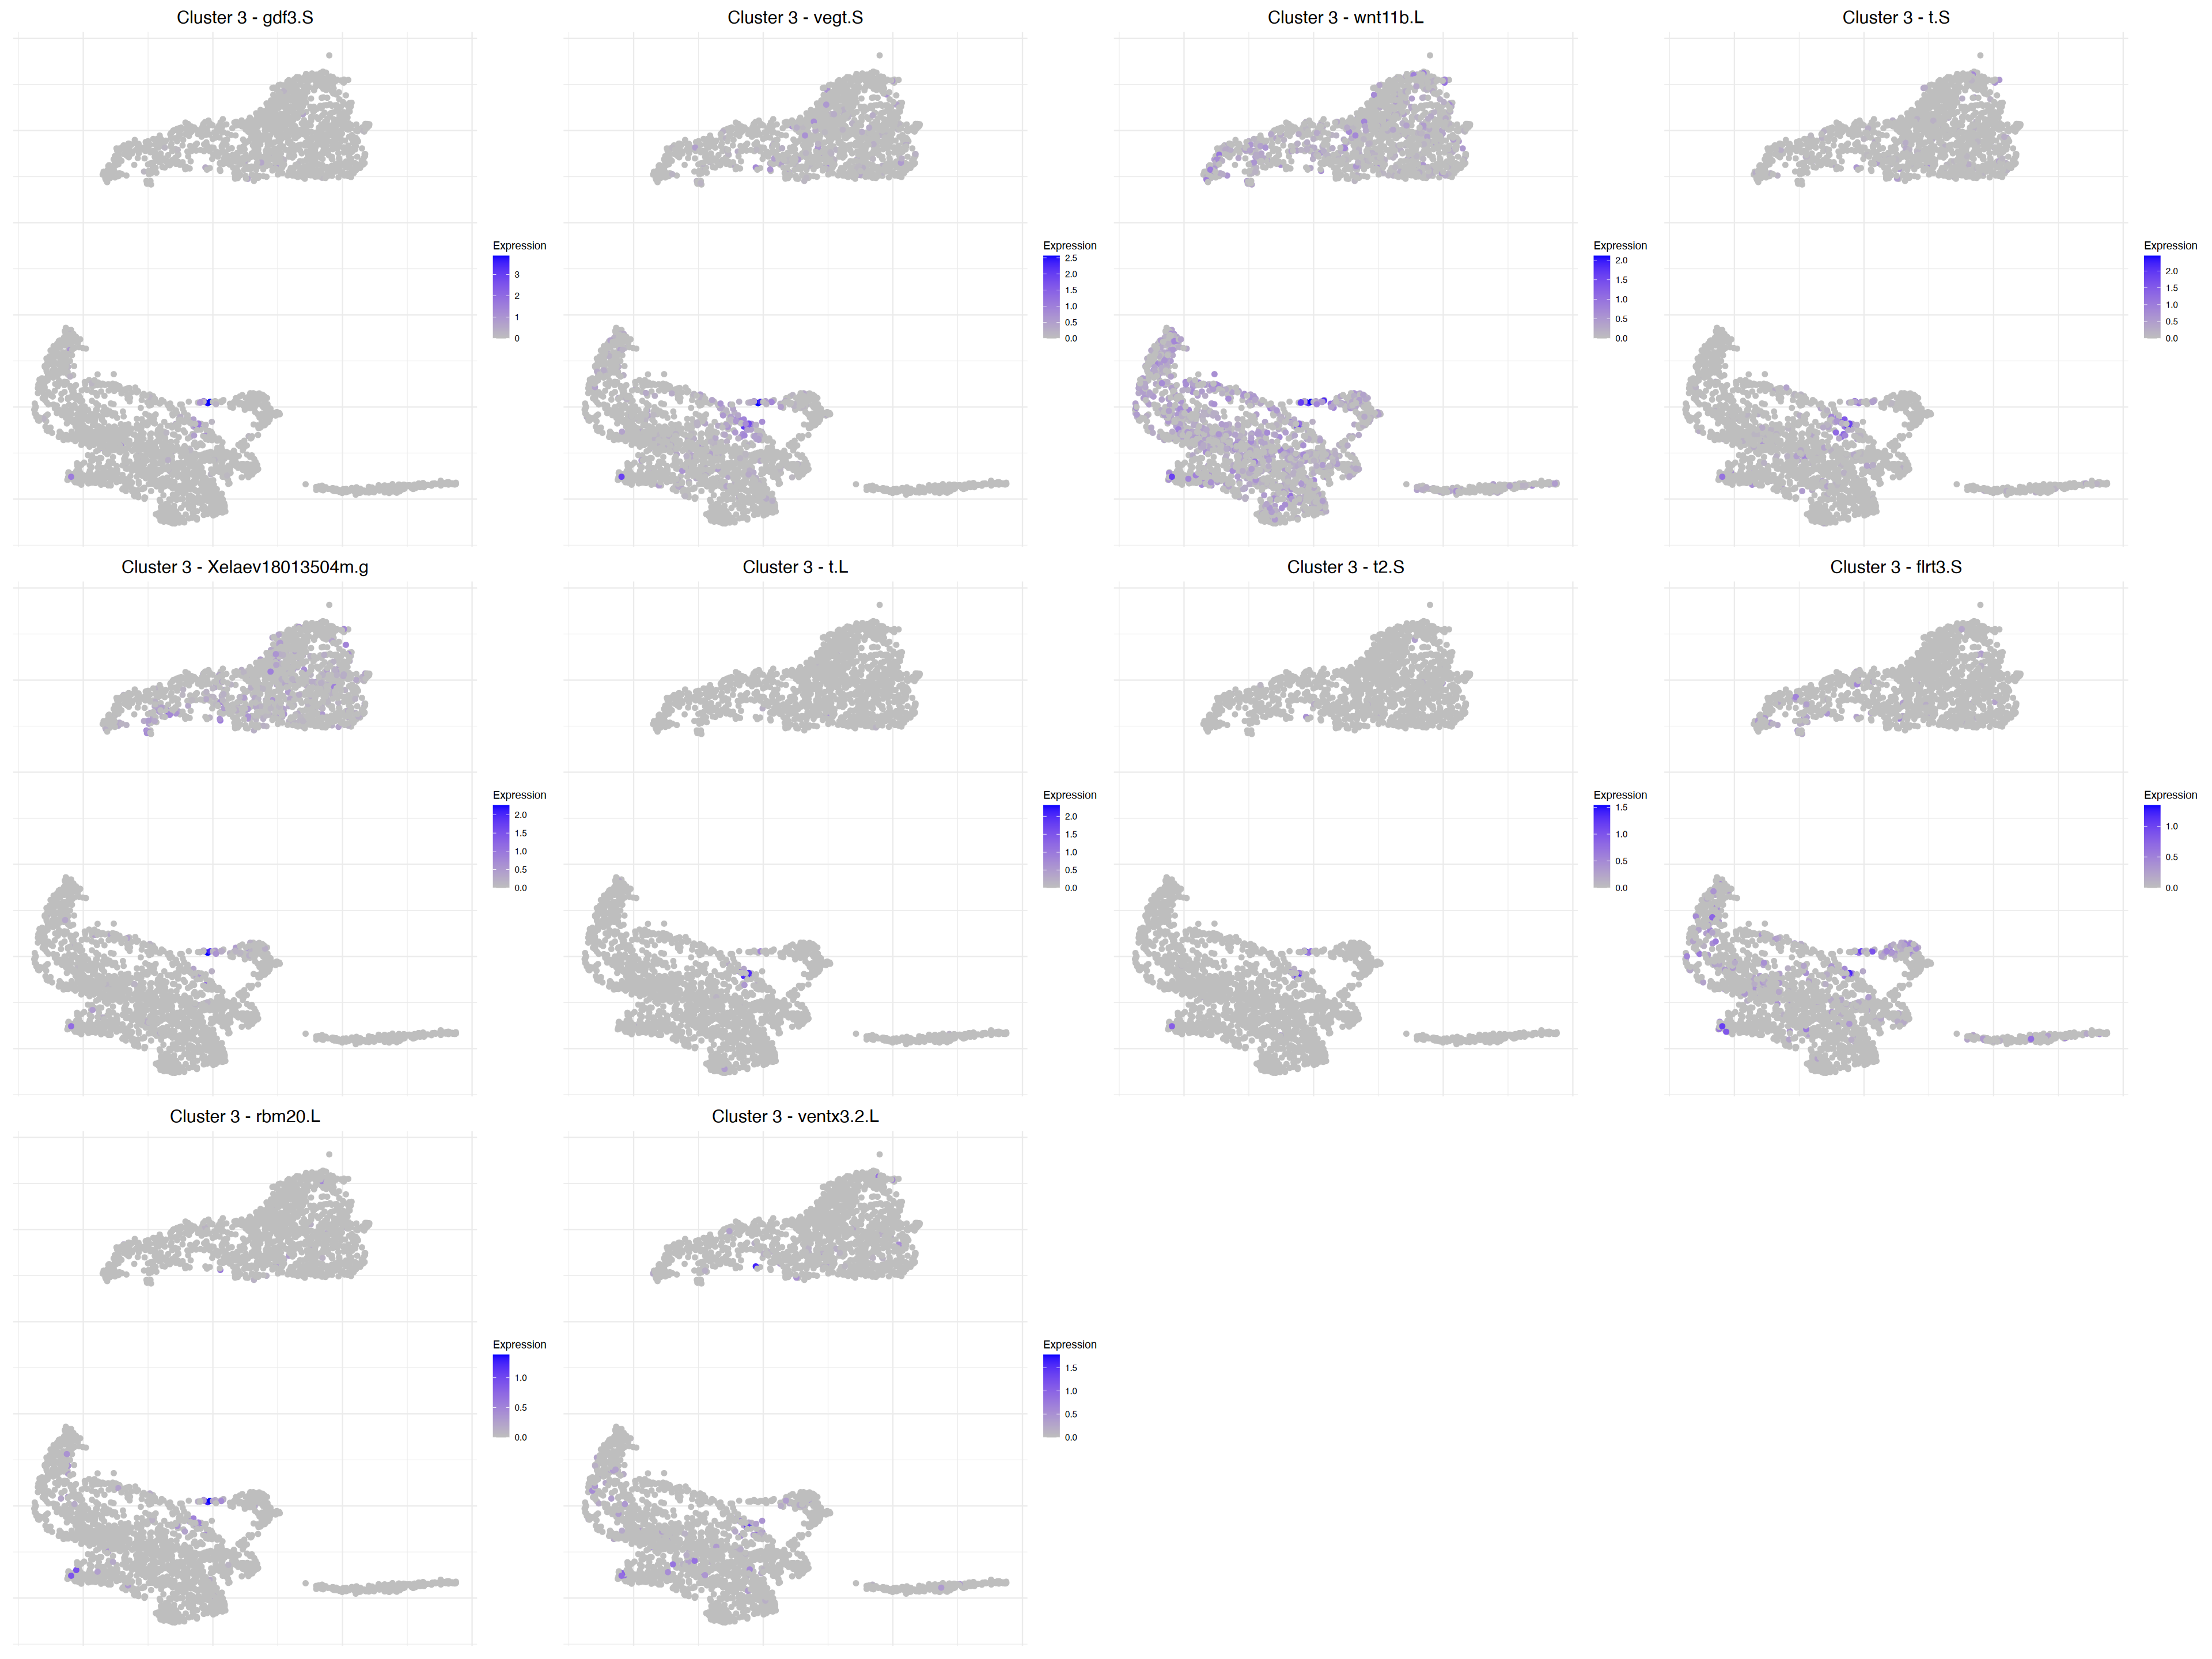

In [40]:
cluster_1_plots <- plot_umap_expression(
  norm_matrix = norm_matrix,
  umap_coordinate = umap_coordinate,
  genes = NULL,  # Genes will be retrieved from `cluster_gene_results`
  cluster = "1",
  cluster_gene_results = cluster_gene_results
)


cluster_3_plots <- plot_umap_expression(
  norm_matrix = norm_matrix,
  umap_coordinate = umap_coordinate,
  genes = NULL,  # Genes will be retrieved from `cluster_gene_results`
  cluster = "3",
  cluster_gene_results = cluster_gene_results
)


# Plot dimensions
plots_per_row <- 4
plot_width <- 8   # Set width for each plot in inches
plot_height <- 8  # Set height for each plot in inches

# Display Cluster 1 plots
options(repr.plot.width = plot_width * plots_per_row, repr.plot.height = plot_height * ceiling(length(cluster_1_plots) / plots_per_row))
cluster_1_grid <- wrap_plots(cluster_1_plots, ncol = plots_per_row)
print(cluster_1_grid)  # Plots for Cluster 1

# Display Cluster 3 plots
options(repr.plot.width = plot_width * plots_per_row, repr.plot.height = plot_height * ceiling(length(cluster_3_plots) / plots_per_row))
cluster_3_grid <- wrap_plots(cluster_3_plots, ncol = plots_per_row)
print(cluster_3_grid)  # Plots for Cluster 3

In [ ]:
# 假设你已经有了 cluster_gene_results 和 cluster_3_hvgs

# 提取 cluster 3 的基因列表
cluster_3_genes <- cluster_gene_results[["3"]]$genes

# 创建列表
combined_genes_list <- list(HLG = cluster_3_genes, HVG = cluster_3_hvgs)

#设定输出档名
output_filename_list <- "../data/generated data from script/cluster_3_HVG_HLG_genes_list.rds"

# 将列表储存成RDS档
saveRDS(combined_genes_list, file = output_filename_list)
cat(paste("Combined cluster 3 genes list saved to:", output_filename_list, "\n"))


# 顯示列表 (可選)
print(combined_genes_list)

In [44]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-apple-darwin20 (64-bit)
Running under: macOS Monterey 12.3

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: Europe/Berlin
tzcode source: internal

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] patchwork_1.1.3             scater_1.28.0              
 [3] scuttle_1.10.3              clustree_0.5.1             
 [5] ggraph_2.1.0                SingleCellExperiment_1.22.0
 [7] SummarizedExperiment_1.30.2 Biobase_2.60.0             
 [9] GenomicRanges_1.52.1        GenomeInfoDb_1.36.4        
[11] IRanges_2.34.1              S4Vectors_0.38.2           
[13] BiocGenerics_0.46